
Identifying safe loans with decision trees
The LendingClub is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to default.

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be charged off and possibly go into default. In this assignment you will:

Use SFrames to do some feature engineering.
Train a decision-tree on the LendingClub dataset.
Visualize the tree.
Predict whether a loan will default along with prediction probabilities (on a validation set).
Train a complex tree model and compare it to simple tree model.
Let's get started!

In [1]:
import pandas as pd
import numpy as np

Load LendingClub dataset
We will be using a dataset from the LendingClub. A parsed and cleaned form of the dataset is availiable here. Make sure you download the dataset before running the following command.

In [2]:
loans=pd.read_csv("lending-club-data.csv")
loans.head()

D:\conda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1



Exploring some features
Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [3]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

In [4]:
loans['grade'].value_counts()
# more that half of the grade values are B and C 

B    37172
C    29950
A    22314
D    19175
E     8990
F     3932
G     1074
Name: grade, dtype: int64


Exploring the target column
The target column (label column) of the dataset that we are interested in is called bad_loans. In this column 1 means a risky (bad) loan 0 means a safe loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:

+1 as a safe loan,
-1 as a risky (bad) loan.
We put this in a new column called safe_loans.

In [5]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop(['bad_loans'],axis=1)

You should have:

Around 81% safe loans
Around 19% risky loans

In [6]:
num_of_val=loans['safe_loans'].shape[0]
count=loans['safe_loans'].value_counts(normalize=True) * 100
print("total number of loans :",num_of_val)
print("percentage : ")
print(count)

total number of loans : 122607
percentage : 
 1    81.118533
-1    18.881467
Name: safe_loans, dtype: float64



Features for the classification algorithm
In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are described in the code comments below. If you are a finance geek, the LendingClub website has a lot more details about these features.

In [7]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = ['safe_loans']                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans1 = loans[features + target]

In [8]:
loans1.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,B,B2,0,11,RENT,27.65,credit_card,36 months,1,1,83.7,0.00,1
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.00,-1
2,C,C5,0,11,RENT,8.72,small_business,36 months,1,1,98.5,0.00,1
3,C,C1,0,11,RENT,20.00,other,36 months,0,1,21.0,16.97,1
4,A,A4,0,4,RENT,11.20,wedding,36 months,1,1,28.3,0.00,1


In [9]:
categorical_features=['grade','sub_grade','home_ownership','purpose']

In [10]:
loans1=pd.get_dummies(loans1)
loans1

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,0,11,27.65,1,1,83.7,0.00,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1.00,1,1,9.4,0.00,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,11,8.72,1,1,98.5,0.00,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,11,20.00,0,1,21.0,16.97,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,4,11.20,1,1,28.3,0.00,1,1,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122602,1,0,1.50,0,0,14.6,0.00,-1,0,0,...,0,0,1,0,0,0,0,0,0,1
122603,0,11,11.26,0,0,15.2,0.00,1,0,0,...,0,0,0,0,0,0,0,0,1,0
122604,0,6,12.28,0,0,10.7,0.00,-1,0,0,...,0,0,1,0,0,0,0,0,0,1
122605,0,11,18.45,1,1,46.3,0.00,-1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
loans1.columns

Index(['short_emp', 'emp_length_num', 'dti', 'last_delinq_none',
       'last_major_derog_none', 'revol_util', 'total_rec_late_fee',
       'safe_loans', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
       'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
       'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
       'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
       'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
       'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
       'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
       'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
       'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_car', 'purpose_credit_card'

Split data into training and validation sets
We split the data into training and validation sets using an 80/20 split and specifying seed=1 so everyone gets the same results.

Note: In previous assignments, we have called this a train-test split. However, the portion of data that we don't train on will be used to help select model parameters (this is known as model selection). Thus, this portion of data should be called a validation set. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of the final selected model should always be on test data. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this assignment, we won't do that.

In [12]:
import json
with open('module-5-assignment-1-train-idx.json', 'r') as f: 
    train_data_index = json.load(f)
    
with open('module-5-assignment-1-validation-idx.json', 'r') as f: 
    validation_data_index = json.load(f)

In [13]:
np.transpose(train_data_index)


array([     1,      6,      7, ..., 122588, 122599, 122603])

In [14]:
np.transpose(validation_data_index)

array([    24,     41,     60, ..., 122445, 122461, 122480])

In [15]:
train_data=loans1.iloc[train_data_index]
validation_data=loans1.iloc[validation_data_index]

In [16]:
train_data.head()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
1,1,1,1.00,1,1,9.4,0.0,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,5,5.55,1,1,32.6,0.0,-1,0,0,...,0,0,0,0,0,1,0,0,0,1
7,1,1,18.08,1,1,36.5,0.0,-1,0,1,...,0,0,0,0,1,0,0,0,0,1
10,1,1,10.08,1,1,91.7,0.0,-1,0,0,...,0,0,0,0,0,0,0,0,1,0
12,0,4,7.06,1,1,55.5,0.0,-1,0,1,...,0,0,0,0,1,0,0,0,1,0


In [17]:
x_train=train_data.drop(['safe_loans'],axis=1)
y_train=train_data['safe_loans']

x_valid=validation_data.drop(['safe_loans'],axis=1)
y_valid=validation_data['safe_loans']

In [42]:
print(x_train.shape)

(37224, 67)


Use decision tree to build a classifier
Now, let's use the built-in GraphLab Create decision tree learner to create a loan prediction model on the training data. (In the next assignment, you will implement your own decision tree learning algorithm.) Our feature columns and target column have already been decided above. Use validation_set=None to get the same results as everyone else.

In [20]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
decision_tree_model=DecisionTreeClassifier(max_depth=6)
decision_tree_model.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

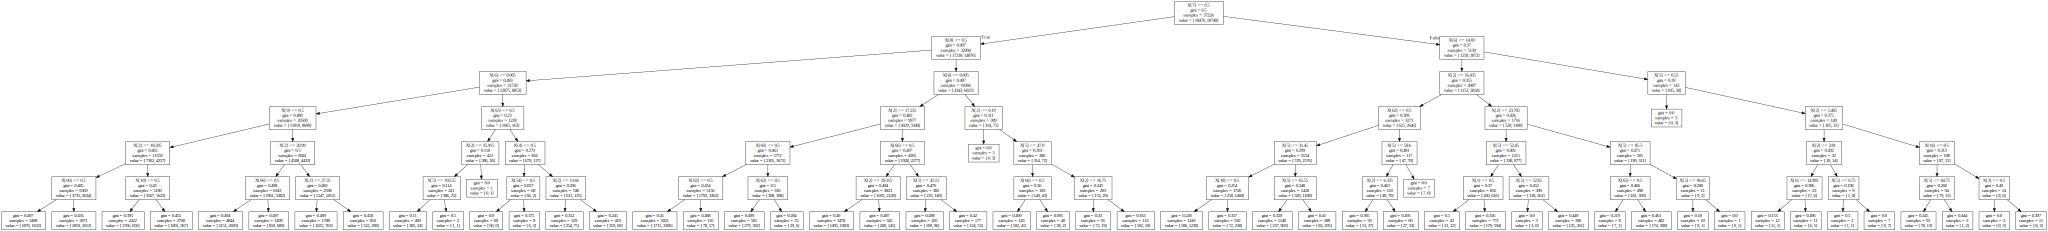

In [37]:
#tree.plot_tree(decision_tree_model) 
import graphviz 
dot_data = tree.export_graphviz(decision_tree_model, out_file=None) 
graph = graphviz.Source(dot_data) 
#graph.render("train_data") 
graph

In [43]:
validation_safe_loans = validation_data[validation_data['safe_loans'] == 1]
validation_risky_loans = validation_data[validation_data['safe_loans'] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data.drop(['safe_loans'],axis=1,inplace=True)


Making predictions
Let's consider two positive and two negative examples from the validation set and see what the model predicts. We will do the following:

Predict whether or not a loan is safe.
Predict the probability that a loan is safe.

In [44]:
decision_tree_model.predict(sample_validation_data)

array([ 1, -1, -1,  1], dtype=int64)

In [46]:
decision_tree_model.predict_proba(sample_validation_data)

array([[0.34156543, 0.65843457],
       [0.53630646, 0.46369354],
       [0.64750958, 0.35249042],
       [0.20789474, 0.79210526]])

In [47]:
small_model=DecisionTreeClassifier(max_depth=2)
small_model.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

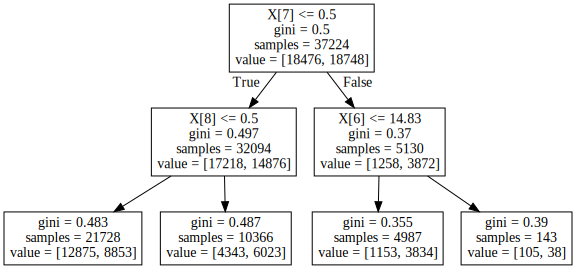

In [48]:
dot_data = tree.export_graphviz(small_model, out_file=None) 
graph = graphviz.Source(dot_data) 
#graph.render("train_data") 
graph

In [49]:
small_model.predict(sample_validation_data)

array([ 1, -1, -1,  1], dtype=int64)

In [50]:
small_model.predict_proba(sample_validation_data)

array([[0.41896585, 0.58103415],
       [0.59255339, 0.40744661],
       [0.59255339, 0.40744661],
       [0.23120112, 0.76879888]])

In [58]:
small_model.predict([sample_validation_data.iloc[1]])

array([-1], dtype=int64)

In [62]:
small_model.score(x_valid,y_valid)

0.6193451098664369

In [63]:
decision_tree_model.score(x_valid,y_valid)

0.6361482119775959

In [64]:
big_model=DecisionTreeClassifier(max_depth=10)
big_model.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [67]:
print("Accuracy on valid data: ",big_model.score(x_valid,y_valid))
print("Accuracy on train data: ",big_model.score(x_train,y_train))

Accuracy on valid data:  0.6265618267987936
Accuracy on train data:  0.6637921770900495


In [68]:
predictions = decision_tree_model.predict(x_valid)

In [69]:
len(predictions)

9284

In [70]:
false_positives = (validation_data[validation_data['safe_loans'] != predictions]['safe_loans'] == -1).sum()
print (false_positives)

1661


In [71]:

false_negatives = (validation_data[validation_data['safe_loans'] != predictions]['safe_loans'] == +1).sum()
print (false_negatives)

1717


In [72]:
cost_of_mistakes = (false_negatives * 10000) + (false_positives * 20000)
print (cost_of_mistakes)

50390000
